# Extract abstract and corpus
Defined variables:
* site: url link to site

Output variables:
* original_abstract: abstract sentence list
* original_corpus: corpus sentence list
* clean_abstract: remove stopwords, lowercased, punctuation, etc. cleaned sentence list of abstract
* clean_corpus: cleaned corpus, list of sentences

Note: original and cleaned versions should have same length, for consistency.
Note each sentence is itself list of words.

NOTE: run sci-spacy and pip installs first, which require runtime restarting, and may override glove etc. imports

In [0]:
import numpy as np
import pandas as pd
import re

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def read_file(filename):
  """
  Obtains original text in filename, in sentence list form.
  """
  reader = open(filename)
  text = ''
  for line in reader:
    text += line + '\n'

  #obtain a sentence list of the original text (abstract or corpus)
  original_text = text.strip().split('.')
  return original_text

In [0]:
def clean_text(original_text, sentence_length_cutoff=5):
  """
  obtain a clean sentence list of original_text
  no punctuation, lowercase, no stop words, and no short sentences
  """
  clean_text = []
  for sentence in original_text:
    sentence = sentence.lower()
    sentence = re.sub("[^a-zA-Z0-9.]", " ", sentence)
    sentence = sentence.split()
    sentence_no_stopwords = [word for word in sentence if word not in stop_words]
    if len(sentence_no_stopwords) < sentence_length_cutoff:
      sentence_no_stopwords = [] #treat it as an empty sentence.
      #we still need something there for a placeholder, for indexing.
    clean_text.append(sentence_no_stopwords)
  return clean_text


In [0]:
#note the length is the same between original versus cleaned.
original_abstract = read_file('abstract_2.txt')
clean_abstract = clean_text(original_abstract)

In [0]:
original_corpus = read_file('corpus_2.txt')
clean_corpus = clean_text(original_corpus)

# Apply GloVe to a corpus
Defined variables:
* clean_corpus

Output variables:
* glove_summary, a list of (score, original sentence, clean sentence, index) sorted highest to lowest score

Note: we can use index to find corresponding clean_corpus sentences if desired.

In [0]:
# download GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-29 13:08:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-29 13:08:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-29 13:08:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
# store a dictionary of word to corresponding GloVe vector
word_to_vec = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_to_vec[word] = coefs
f.close()

## Vectorize corpus
Output
* vec_corpus, list of vectors. 1 vector for each sentence.

In [0]:
def vectorize_word(w):
  """
  Returns the 100-dimension GloVe vector for a word, or zero vector if not found.
  """
  return word_to_vec.get(w, np.zeros((100,)))

In [0]:
def vectorize_summary(clean_sentence_list):
  """
  Returns a list of vectors, where each vector represents the vector of a sentence.
  The vector of each sentence is the mean of the vectors of the words in the sentence.
  """
  vec_sentences = []
  for sentence in clean_sentence_list:
    vec_sentences.append(np.mean(
        np.array([vectorize_word(w) for w in sentence])
        , axis=0))
  return vec_sentences

In [0]:
vec_glove_corpus = vectorize_summary(clean_corpus)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Obtain Similarity Matrix
Input
* vec_glove_corpus or vec_cui_corpus

Output
* matrix_glove_corpus or matrix_cui_corpus: similarity matrix of vec_glove_corpus

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
def get_sim_matrix(vec_sentences, vec_length):
  """
  vec_length is 100 for gloVe, and 500 for Cui2vec
  """
  similarity_matrix = np.zeros(
      [len(vec_sentences), len(vec_sentences)], dtype=float)
  #two perpendicular vectors have 0 similarity, because cosine of 90 is 0.

  for i in range(len(vec_sentences)):
    for j in range(len(vec_sentences)):
      if i != j:
          if np.isnan(np.sum(vec_sentences[i])) or np.isnan(np.sum(vec_sentences[j])):
            similarity_matrix[i][j] = 0
            #one of them is nan
          else:
            similarity_matrix[i][j] = cosine_similarity(
                vec_sentences[i].reshape(1,vec_length), # because 100 dimension GloVe vector
                vec_sentences[j].reshape(1,vec_length))[0,0]
  return similarity_matrix

In [0]:
matrix_glove_corpus = get_sim_matrix(vec_glove_corpus, 100)

# Perform TextRank
Input:
* matrix_glove_corpus, or matrix_cui_corpus
* original_corpus
* clean_corpus

Output:
* glove_summary, or cui_summary

In [0]:
import networkx as nx

In [0]:
def textrank(sim_matrix, original_text, clean_text, top_n=5):
  """
  Get the top_n sentences via textrank on the sim_matrix
  select corresponding text from original_text (uncleaned sentence list)
  """
  graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(graph) #each of the sentences, and corresponding score

  ranked_sentences = sorted((
      (scores[i],orig_sentence, clean_text[i], i) for i,orig_sentence in enumerate(original_text)), 
      reverse=True)
  print("Summary:")
  for i in range(top_n):
    print (ranked_sentences[i][1].strip()) #just print the sentence for viewing
    #some original sentences still had \n attached, so strip
  return ranked_sentences


In [0]:
top_n = 5#len(original_abstract) #or 5

In [0]:
glove_summary = textrank(matrix_glove_corpus, original_corpus, clean_corpus, top_n=top_n)

Summary:
Our analyses showed that trap evolution was associated with significant expansion of multiple gene familiesand many of them may function in pathogenicity of the nematode-trapping fungi
The combined anal-ysis showed that the expansion of genes encoding adhesion proteins (APs) among fungal genomes andtheir up-regulation during the fungal lifestyle change were responsible for the increasing adhesivenesson trap surface, driving the evolution of the nematode-trapping fungi and their adaptation in capturingnematodes using different trapping devices
To further study thepathogenic adaptation of the nematode-trapping fungi at the genome level, the phylogenomic relation-ships among the representative NTF were constructed using the maximum likelihood method based on395 conserved genes coding for orthologous proteins
Interestingly, the species-specific genes were found enriched in many of the expanded path-ogenicity-related gene families (Figure S2)
For example, three gene families, inclu

# Apply Cui2Vec to a Corpus

Defined variables:
* clean_corpus

Output variables:
* cui_summary

## Install scispacy

In [0]:
#!pip install scispacy

In [0]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

     |████████████████████████████████| 17.0MB 225kB/s 
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.2.4-cp36-none-any.whl size=17161110 sha256=8f36195e91e26c362026811bd4546f15d64b6530a800858eb09b635bd4d3da54
  Stored in directory: /root/.cache/pip/wheels/34/60/b9/fabd9c3eeba17ed66df745479f2fc502a6702755cb4a9632f2
Successfully built en-core-sci-sm


In [0]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
import spacy
import scispacy
import en_core_sci_sm   #The model we are going to use
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

In [0]:
nlp_reader = en_core_sci_sm.load()
cui_linker = UmlsEntityLinker(resolve_abbreviations=True)
nlp_reader.add_pipe(cui_linker) # Each entity is linked to UMLS with a score# (currently just char-3gram matching).

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmpzoq2apwg
Finished download, copying /tmp/tmpzoq2apwg to cache at /root/.scispacy/datasets/ea855fd121a193f03190a91417c209d4cd97e63d3ce4b456c248ef7c13a4ca77.03518aabd12de2103a27a50302f37c3d87b0f313a8be08b5ec306c9c4334b9b1.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/nmslib_index.bin not found in cache, downloading to /tmp/tmpckf34jye
Finished download, copying /tmp/tmpckf34jye to cache at /root/.scispacy/datasets/5f620d1bd549a98c005ed601a73806ea2cd1a86ae6c54bbc62bcb3b452ca2630.27a7ac6807fde6628311ff7d70b86fefc640d0eb70637b544c591722a2c16c2a.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpmn4t15vv
Finished download, copying /tmp/tmpmn4t15vv to cache at /root/.scispacy/datasets/ffb7a77cdcb3c9233c1e400

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linking_model/concept_aliases.json not found in cache, downloading to /tmp/tmppr6s_uqd
Finished download, copying /tmp/tmppr6s_uqd to cache at /root/.scispacy/datasets/0f064d20aefab965d5772b2100f8436b3541e7d5313c76cfe5fe070902f149fe.31df9cdb04729860a81bd6c980224ed2bff582586c398d0c9b96ae4e257b9da2.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_2017_aa_cat0129.json not found in cache, downloading to /tmp/tmpkpvkekgb
Finished download, copying /tmp/tmpkpvkekgb to cache at /root/.scispacy/datasets/13b30cd31cd37c1b52f3df6ea023061172d16e9941660e677fdbb29489af7410.4ad71d86ce780e00cab131c7e3b81acfd2f11dd80ccd61125c8bcde506f2ab8a.umls_2017_aa_cat0129.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmp3hy09ud1
Finished download, copying /tmp/tmp3hy09ud1 to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Load cui2vec

In [0]:
!wget https://ndownloader.figshare.com/files/10959626?private_link=00d69861786cd0156d81 -O cui2vec_pretrained.csv.zip

--2020-04-29 13:18:50--  https://ndownloader.figshare.com/files/10959626?private_link=00d69861786cd0156d81
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 99.81.73.117, 52.17.144.100, 52.212.2.22, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|99.81.73.117|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10959626/cui2vec_pretrained.csv.zip [following]
--2020-04-29 13:18:50--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10959626/cui2vec_pretrained.csv.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.41.179
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.41.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482307559 (460M) [binary/octet-stream]
Saving to: ‘cui2vec_pretrained.csv.zip’

cui2vec_pretrained. 100%[===================>] 459.96M  72.2MB/s    in 5.8s    

2020-04

In [0]:
!unzip cui2vec_pretrained.csv.zip #or try taking out the .zip

Archive:  cui2vec_pretrained.csv.zip
  inflating: cui2vec_pretrained.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._cui2vec_pretrained.csv  


In [0]:
import numpy as np
import pandas as pd
embeddings = pd.read_csv("cui2vec_pretrained.csv")

In [0]:
def word_list_to_sent_list(clean_text):
  """
  converts to format where each entry of list is a sentence
  """
  output = []
  for sentence in clean_text:
    if len(sentence) == 0:
      output.append('')
    else:
      output.append(' '.join(sentence))
  return output

## Find entities in each sentence

In [0]:
def clean_sent_list_to_ent_list(clean_sentence_list):
  """
  Takes clean sentence list, such as ['sentence is here', 'sentence is here'].
  Note this isn't quite the same as clean_corpus, where each sentence is further a list of words.
  """
  sent_list = []
  for s in clean_sentence_list:
    sent_list.append(list(nlp_reader(s).ents)) #might be blank.
  return sent_list

## Entity to vector

In [0]:
def ent_to_vec(entity, cap = 3):
  vecsum = np.zeros((500,))
  maxrange = min(cap, len(entity._.umls_ents))
  for i in range(maxrange):
    cuii, scorei = entity._.umls_ents[i]
    v = cui_to_vec(cuii)
    vecsum += scorei*v
  if maxrange > 0:
    return vecsum/maxrange 
  return np.zeros((500,)) # if maxrange is 0, then just return
  #return np.mean(vecs, axis=0)

## Convert a cui to vector representation

In [0]:
def cui_to_vec(cui):
  cui = str(cui).upper()
  s = embeddings.loc[embeddings['Unnamed: 0'] == cui] #make sure to run embeddings = pd.read_csv...
  vec = s.drop("Unnamed: 0", axis=1)
  if s.shape[0] == 0: #if not available cui, then return 0 (i.e. 0 rows)
    return np.zeros((500,))
  return np.array(vec).ravel()

## Convert sentence list to vector list

In [0]:
def entList_to_vec(ent_list):
 # if len(ent_list) == 0:
  #  return np.zeros()
  outputsum = np.zeros((500,))
  nonzero_count = 0
  for ent in ent_list:
    v = ent_to_vec(ent)
    if np.sum(v) == 0:
      continue
    nonzero_count += 1
    outputsum += v
  if nonzero_count == 0:
    return np.zeros((500,))
  return outputsum/nonzero_count

In [0]:
def sentList_to_vecList(sent_list):
  vec_list = []
  for ent_list in sent_list:
    vec_list.append(entList_to_vec(ent_list))
  return vec_list

In [0]:
entity_list_list = clean_sent_list_to_ent_list(word_list_to_sent_list(clean_corpus))

In [0]:
vec_cui_corpus = sentList_to_vecList(entity_list_list)

## Similarity Matrix

In [0]:
matrix_cui_corpus = get_sim_matrix(vec_cui_corpus, 500)

## Perform TextRank

In [0]:
top_n = 5#len(original_abstract) # can use 5

In [0]:
cui_summary = textrank(matrix_cui_corpus, original_corpus, clean_corpus, top_n=top_n)

Summary:
These molecules play critical roles in the establishment of fungal infectionsof plants, animals, and humans
Comparative Genomic Analyses Reveal Expansion of Genes Encoding Adhesion ProteinsTo further investigate the underlying genetic basis for pathogenic adaptation of the nematode-trapping fungi,genomic and comparative genomic analyses were performed
The formation of trapping devices is the key indicator of their lifestyle transition from saprophytes to predators and thus makes them good models for studying the mechanisms of fungal pathogenesis and adaptation(Abad et al
In the NTF genomes,the genes encoding adhesion proteins were significantly expanded and the expansion paralleled the increasing adhesiveness of the trapping devices (Figures 3A and 3B)
Genes Encoding Adhesion Proteins Show Consistent Up-RegulationsTo further investigate the relationship between adhesion proteins and trap induction of NTF, quantitativeRT-PCR was performed to measure the gene expression levels o

# Evaluate summary against abstract
Defined variables:
* original_abstract
* clean_abstract
* glove_summary
* cui_summary

Output variables:

ROUGE n-gram implementation

## Direct comparison by eye

In [0]:
top_n = 5#len(original_abstract)

In [0]:
def direct_comparison(summary, abstract, top_n=5):
  summary_string = ''
  for _,_,_,i in summary[0:top_n]:
    summary_string += original_corpus[i].strip() + '. '
  abstract_string = '. '.join(abstract)
  return summary_string, abstract_string

In [0]:
s_cui,a = direct_comparison(cui_summary, original_abstract, top_n=top_n)

In [0]:
print(s_cui) #print generated summary

These molecules play critical roles in the establishment of fungal infectionsof plants, animals, and humans. Comparative Genomic Analyses Reveal Expansion of Genes Encoding Adhesion ProteinsTo further investigate the underlying genetic basis for pathogenic adaptation of the nematode-trapping fungi,genomic and comparative genomic analyses were performed. The formation of trapping devices is the key indicator of their lifestyle transition from saprophytes to predators and thus makes them good models for studying the mechanisms of fungal pathogenesis and adaptation(Abad et al. In the NTF genomes,the genes encoding adhesion proteins were significantly expanded and the expansion paralleled the increasing adhesiveness of the trapping devices (Figures 3A and 3B). Genes Encoding Adhesion Proteins Show Consistent Up-RegulationsTo further investigate the relationship between adhesion proteins and trap induction of NTF, quantitativeRT-PCR was performed to measure the gene expression levels of APs

In [0]:
print(a) #print abstract

Understanding how fungi interact with other organisms has significant medical, environmental, and agricultural implications.  Nematode-trapping fungi (NTF) can switch to pathogens by producing various trapping devices to capture nematodes.  Here we perform comparative genomic analysis of the NTF with four representative trapping devices.  Phylogenomic reconstruction of these NTF suggested an evolutionary trend of trapping device simplification in morphology.  Interestingly, trapping device simplification was accompanied by expansion of gene families encoding adhesion proteins and their increasing adhesiveness on trap surfaces.  Gene expression analysis revealed a consistent up-regulation of the adhesion genes during their lifestyle transition from saprophytic to nematophagous stages.  Our results suggest that the expansion of adhesion genes in NTF genomes and consequential increase in trap surface adhesiveness are likely the key drivers of fungal adaptation in trapping nematodes, provi

In [0]:
s_glove,a = direct_comparison(glove_summary, original_abstract)

In [0]:
print(s_glove)

Our analyses showed that trap evolution was associated with significant expansion of multiple gene familiesand many of them may function in pathogenicity of the nematode-trapping fungi. The combined anal-ysis showed that the expansion of genes encoding adhesion proteins (APs) among fungal genomes andtheir up-regulation during the fungal lifestyle change were responsible for the increasing adhesivenesson trap surface, driving the evolution of the nematode-trapping fungi and their adaptation in capturingnematodes using different trapping devices. To further study thepathogenic adaptation of the nematode-trapping fungi at the genome level, the phylogenomic relation-ships among the representative NTF were constructed using the maximum likelihood method based on395 conserved genes coding for orthologous proteins. Interestingly, the species-specific genes were found enriched in many of the expanded path-ogenicity-related gene families (Figure S2). For example, three gene families, including 

## Rouge

In [0]:
!pip install easy-rouge

In [0]:
from rouge.rouge import rouge_n_summary_level

In [0]:
def clean_summary_only(summary, top_n=5):
  """
  Extract only the clean summary sentences
  summary: [ (score, orig sentence, clean sentence, index), ...]
  """
  top_n = min(top_n, len(summary))
  return [summary[i][2] for i in range(top_n)]

In [0]:
def flatten_sentence_list(sentence_list):
  """
  joins all the words in sentence list into a single string
  """
  output = ''
  for sentence in sentence_list:
    output += ' '.join(sentence) + '. '
  return output

In [0]:
def rouge(summary, abstract):
  # make sure theyre flattened to a single string
  flat_summary = flatten_sentence_list(summary)
  flat_abstract = flatten_sentence_list(abstract)
  recall, precision, fscore = rouge_n_summary_level(flat_summary, flat_abstract, 1)
  print('ROUGE-1-R', recall)
  print('ROUGE-1-P', precision)
  print('ROUGE-1-F', fscore)

In [0]:
# get the summary words only
clean_cui_summary = clean_summary_only(cui_summary)
clean_glove_summary = clean_summary_only(glove_summary)

In [0]:
# apply rouge to compare
rouge(clean_cui_summary, clean_abstract)

ROUGE-1-R 0.9058050383351588
ROUGE-1-P 0.9775413711583925
ROUGE-1-F 0.9403069926094372


In [0]:
rouge(clean_glove_summary, clean_abstract)

ROUGE-1-R 0.9561883899233297
ROUGE-1-P 0.9141361256544502
ROUGE-1-F 0.9346895074946466


## Histogram of scores

In [0]:
import matplotlib.pyplot as plt

In [0]:
# how many are zeros (e.g. in matrix also)

In [0]:
def scores(summary):
  return [summary[i][0] for i in range(len(summary))]

In [0]:
cui_scores = scores(cui_summary)
glove_scores = scores(glove_summary)

(array([41.,  0.,  0.,  1.,  4.,  5.,  6., 25., 72., 59.]),
 array([0.00084244, 0.00141196, 0.00198148, 0.00255101, 0.00312053,
        0.00369005, 0.00425958, 0.0048291 , 0.00539862, 0.00596814,
        0.00653767]),
 <a list of 10 Patch objects>)

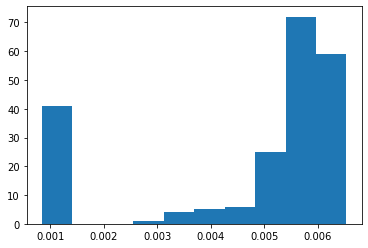

In [0]:
plt.hist(glove_scores)

(array([51.,  4.,  2.,  1., 13., 18., 34., 30., 49., 11.]),
 array([0.00088423, 0.00159733, 0.00231043, 0.00302353, 0.00373663,
        0.00444973, 0.00516283, 0.00587592, 0.00658902, 0.00730212,
        0.00801522]),
 <a list of 10 Patch objects>)

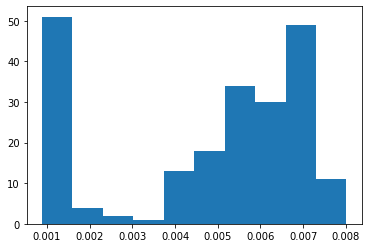

In [0]:
plt.hist(cui_scores)

## Matrix visualization
Input:
* matrix_text (matrix_glove_corpus, matrix_cui_corpus)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def visualize_matrix(matrix_text, remove_blank_sentences=True):
  """
  Plots similarity matrix of sentence vectors.
  Option to remove blank sentences with 0 similarity.
  """
  if not remove_blank_sentences:
    plt.matshow(matrix_text, cmap=plt.cm.Blues)
    plt.show()
    return

  # remove all the zero'd sentences
  no_zero_mat = matrix_text[~np.all(matrix_text == 0, axis=1)]
  no_zero_mat = no_zero_mat[:,~np.all(no_zero_mat == 0, axis=0)]
  plt.matshow(no_zero_mat, cmap=plt.cm.Blues)
  plt.show()

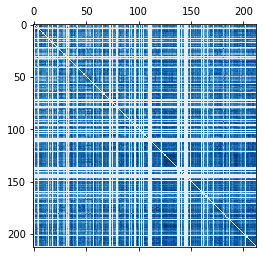

In [0]:
visualize_matrix(matrix_glove_corpus, remove_blank_sentences=False)

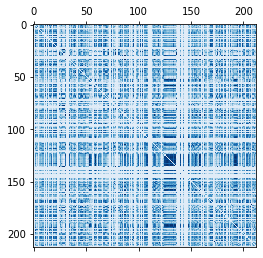

In [0]:
visualize_matrix(matrix_cui_corpus, remove_blank_sentences=False)

# Additional notes
* why sentence importance and length are correlated

In [0]:
def plot_length_vs_importance(summary):
  y = [(stc[0], len(stc[1])) for stc in summary]
  plt.scatter(*zip(*y))
  plt.xlabel("Importance Score")
  plt.ylabel("Sentence Length (chars)")
  plt.show()

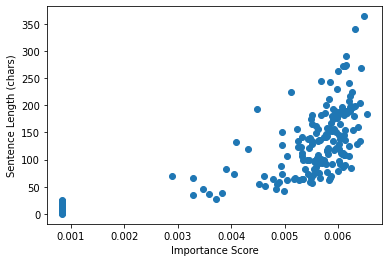

In [0]:
plot_length_vs_importance(glove_summary)

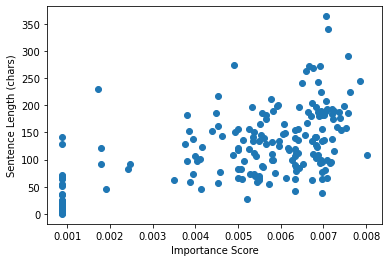

In [0]:
plot_length_vs_importance(cui_summary)